In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import sys,time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
import gibbs
from concrete import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [204]:
# data generation
np.random.seed(2023)
N=100
K=3
true_mu=np.array([-7.5,0,7.5])
true_tau=0.4*np.ones(3)
true_w=np.array([0.2,0.5,0.3])

x=np.random.choice(np.arange(K,dtype=int),size=N,p=true_w)
y=true_mu[x]+np.random.randn(N)/np.sqrt(true_tau[x])

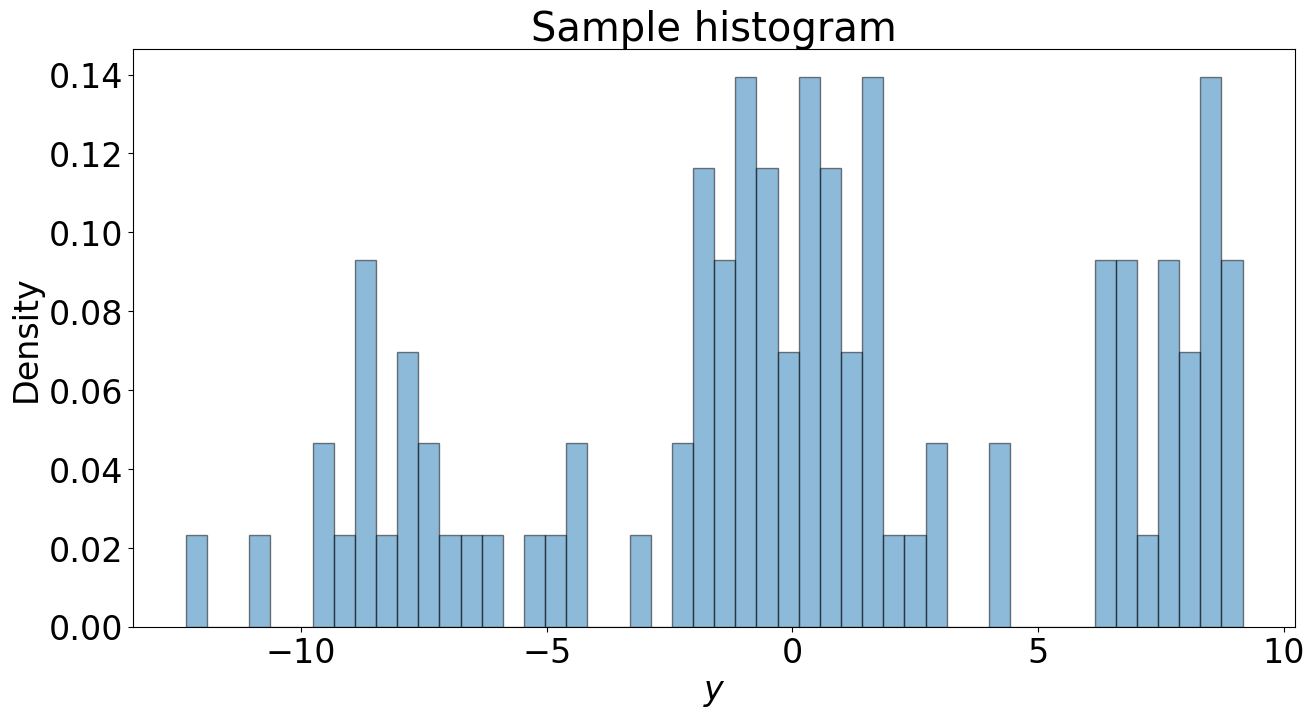

In [205]:
plt.hist(y,bins=50,alpha=0.5,ec='black',density=True)
plt.xlabel(r'$y$')
plt.ylabel('Density')
plt.title('Sample histogram');

## Real NVP with Concrete for labels

In [206]:
import torch
import torch.distributions

In [207]:
class GMMRef(Distribution):
    def __init__(self, N,K,tau0=1.,temp=1.):
        self.relcat = ExpRelaxedCategorical(torch.tensor([temp]),torch.ones(K)/K)
        self.gauss  = torch.distributions.MultivariateNormal(torch.zeros(K), torch.eye(K)/np.sqrt(tau0))
        
    def log_prob(self, value):
        mvn_lp = self.gauss.log_prob(value[...,:K])
        relcat_lp = torch.zeros(value.shape[0])
        for n in range(N): relcat_lp += self.relcat.log_prob(value[...,K+n*K+torch.arange(0,K)])
        return relcat_lp+mvn_lp

    def sample(self,sample_shape=torch.Size()):
        relcat_sample=self.relcat.sample(sample_shape)
        for n in range(N-1): relcat_sample = torch.hstack((relcat_sample,self.relcat.sample(sample_shape)))
        mvn_sample=self.gauss.sample(sample_shape)
        return torch.hstack((mvn_sample,relcat_sample))

In [202]:
ref=GMMRef(N,K,tau0=tau0,temp=1.)

In [317]:
def createGMMRealNVP(temp,depth,N,K,tau0,width=32):
    """
    Wrapper to init a RealNVP class for a GMM problem

    The reference distribution is a relaxed uniform in exp space
    for the labels and a multivariate normal with precision tau0
    for the means

    Inputs:
        temp   : float, temperature of Concrete relaxation
        depth  : int, number of couplings (transformations)
        N      : int, number of observations from the GMM
        K      : int, mixture size
        tau0   : float, prior precision for means
        width : int, width of the linear layers

    Outputs:
        flow   : Module, RealNVP
    """
    dim=K*(N+1)

    # create channel-wise masks of appropriate size
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)

    # define reference distribution
    ref = GMMRef(N,K,tau0,temp)

    # define scale and translation architectures
    net_s = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim),
        nn.Tanh()
    )
    net_t = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim)
    )
    return RealNVP(net_s, net_t, masks, ref)

In [318]:
def trainGMMRealNVP(temp,depth,N,K,tau0,sample,width=32,max_iters=1000,lr=1e-4,mc_ss=1000,seed=0,verbose=True):
    """
    Train a RealNVP normalizing flow targeting lprbs using the Adam optimizer

    Input:
        temp      : float, temperature of Concrete relaxation
        depth     : int, number of couplings (transformations)
        N         : int, number of observations from the GMM
        K         : int, mixture size
        tau0      : float, prior precision for means
        sample    : (B,K*(N+1)) array, samples from target for training; B is the Monte Carlo sample size
        width     : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        mc_ss     : int, number of samples to draw from target for training
        seed      : int, for reproducinility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam
    """
    torch.manual_seed(seed)

    # create flow
    flow=createGMMRealNVP(temp,depth,N,K,tau0,width)

    # train flow
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)

    for t in range(max_iters):
        loss = -flow.log_prob(sample).mean()
        losses[t]=loss

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

In [211]:
tau0=0.1
steps=1000
pred_x,pred_mu=gibbs.gibbs_gmm(y,true_w,true_tau,tau0,steps,burnin_pct=0.9,verbose=True,seed=2023)

In [306]:
# estimate probabilities of each xn
print(pred_x.T)
ttt=np.hstack((((pred_x.T==0).astype(int)),(pred_x.T==1).astype(int),(pred_x.T==2).astype(int)))
tttt=np.copy(ttt)
for n in range(N): tttt[:,n*K+np.arange(0,K,dtype=int)]=ttt[:,n::100]
print(tttt)

[[0. 1. 0. ... 1. 2. 1.]
 [0. 1. 0. ... 1. 2. 1.]
 [0. 1. 0. ... 1. 2. 1.]
 ...
 [0. 1. 0. ... 1. 2. 1.]
 [0. 1. 0. ... 1. 2. 1.]
 [0. 1. 0. ... 1. 2. 1.]]
[[1 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]
 [1 0 0 ... 0 1 0]]


In [298]:
# estimate probabilities of each xn
x_prbs=np.sum(pred_x==np.arange(0,K,dtype=int)[:,np.newaxis,np.newaxis],axis=-1)
x_prbs=(x_prbs/np.sum(x_prbs,axis=0)[np.newaxis,:]).T
print(x_prbs[0,:])

[1. 0. 0.]


In [312]:
G=np.random.gumbel(size=(pred_x.shape[-1],x_prbs.shape[0],x_prbs.shape[1]))
temp=1.
ssample=(x_prbs[np.newaxis,...]+G)/temp-np.log(np.sum(np.exp((x_prbs[np.newaxis,...]+G)/temp),axis=-1))[...,np.newaxis]
ssample=ssample.reshape(pred_x.shape[-1],x_prbs.shape[0]*x_prbs.shape[1])
print(ssample.shape)
print(pred_mu.shape)

(1000, 300)
(3, 1000)


In [323]:
final_sample=torch.tensor(np.hstack((ssample,pred_mu.T))).float()
print(final_sample.shape)

torch.Size([1000, 303])


In [325]:
temp=1.
depth=5
tau0=0.1
trainGMMRealNVP(temp,depth,N,K,tau0,final_sample,width=32,max_iters=1001,lr=1e-2,mc_ss=1000,seed=0,verbose=True)

iter 0: loss = 458.803
iter 100: loss = 357.316
iter 200: loss = 346.541
iter 300: loss = 338.007
iter 400: loss = 330.499
iter 500: loss = 326.841
iter 600: loss = 317.334
iter 700: loss = 312.698
iter 800: loss = 308.229
iter 900: loss = 306.660
iter 1000: loss = 298.274


(RealNVP(
   (t): ModuleList(
     (0-3): 4 x Sequential(
       (0): Linear(in_features=303, out_features=32, bias=True)
       (1): LeakyReLU(negative_slope=0.01)
       (2): Linear(in_features=32, out_features=32, bias=True)
       (3): LeakyReLU(negative_slope=0.01)
       (4): Linear(in_features=32, out_features=303, bias=True)
     )
   )
   (s): ModuleList(
     (0-3): 4 x Sequential(
       (0): Linear(in_features=303, out_features=32, bias=True)
       (1): LeakyReLU(negative_slope=0.01)
       (2): Linear(in_features=32, out_features=32, bias=True)
       (3): LeakyReLU(negative_slope=0.01)
       (4): Linear(in_features=32, out_features=303, bias=True)
       (5): Tanh()
     )
   )
 ),
 array([458.80282593, 488.51251221, 429.66766357, ..., 299.66638184,
        299.03924561, 298.27441406]))

In [213]:
pred_mu.shape

(3, 1000)